# Assignment 8

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Plotting defaults 
plt.rcParams.update({
    "figure.figsize": (6, 4),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 12,
})

# Reproducible RNG (used throughout the notebook)
rng = np.random.default_rng(8)


## Setup and helper functions (from Assignment 7)

We start from the 2D Ising Hamiltonian in a uniform external field $B$,
written in reduced units $I = \mu_B = k_B = 1$:

$$
H(\{s_i\}) \;=\; - B \sum_{i=1}^{N} s_i
\;-\; \frac{1}{2}\sum_{i=1}^{N} \sum_{j\in\Lambda_i} s_i s_j,
\qquad s_i=\pm 1,
$$

where $\Lambda_i$ denotes the four nearest neighbours of site $i$ on an $S\times S$ square lattice with periodic boundaries.

Below we implement helper functions for this model - similar to those of Assignment 7:

* a routine that computes the total energy $H$ of a given spin configuration,
* a function that returns the total magnetisation $M$,
* a **Metropolis sweep** that attempts to flip every spin once,
* a driver `run_ising_2d` that performs many sweeps and records time series of
  the energy and magnetisation per spin.


Firstly, we introduce a function that computes the total energy:


In [2]:
def total_energy_2d(spins, B=0.0):
    '''Compute the total energy H of a 2D Ising configuration with periodic boundaries.

    We work in units where I = mu_B = k_B = 1, so the Hamiltonian reads

        H({s}) = - B * sum_i s_i - (1/2) * sum_i sum_{j in Λ_i} s_i s_j ,

    where Λ_i are the four nearest neighbours of site i.

    Parameters
    ----------
    spins : ndarray of shape (S, S), dtype int
        Lattice of spins taking values in {+1, -1}.
    B : float, default 0.0
        External magnetic field.

    Returns
    -------
    U : float
        Total energy of the configuration.
    '''
    # Field term: - B \sum_i s_i
    field = - B * spins.sum()

    # Nearest neighbours via periodic rolls along both axes
    up    = np.roll(spins,  1, axis=0)
    down  = np.roll(spins, -1, axis=0)
    left  = np.roll(spins,  1, axis=1)
    right = np.roll(spins, -1, axis=1)
    neigh_sum = up + down + left + right

    # Interaction term: - (1/2) \sum_i s_i sum_{j in Λ_i} s_j
    # (the factor 1/2 avoids double counting of bonds)
    inter = -0.5 * np.sum(spins * neigh_sum)

    return float(field + inter)


Next, we introduce a helper that computes the total magnetisation
$$
M = \sum_i s_i.
$$

In [3]:
def magnetisation_2d(spins):
    '''Compute the extensive magnetisation M = sum_i s_i.

    Parameters
    ----------
    spins : ndarray (S, S)
        Spin configuration with entries ±1.

    Returns
    -------
    M : float
        Extensive magnetisation. Divide by N = S^2 for the magnetisation per site.
    '''
    return float(spins.sum())


We now implement a single **Metropolis sweep**.

Algorithm (one sweep at fixed $T$ and $B$):

1. Visit all $N = S^2$ sites in a random order.
2. For each site $(i,j)$ with spin $s_{ij}$:
   * compute the sum of the four neighbours $s_{\text{neigh}}$,
   * compute the energy change for a flip $s_{ij}\to -s_{ij}$,
     $\Delta U = 2 s_{ij} (B + s_{\text{neigh}})$,
   * accept the flip if $\Delta U\le 0$; otherwise accept it with probability
     $\exp(-\Delta U/T)$.
3. After this, every spin has been **proposed** for an update exactly once.

This constitutes one *sweep*. Notice that the computational cost is $O(N)$,
and using a random visiting order avoids systematic biases.

In [4]:
def metropolis_sweep_2d(spins, T, B=0.0, rng=None):
    '''Perform one Metropolis sweep visiting each site once in random order.

    Parameters
    ----------
    spins : ndarray (S, S), modified in place
        Current spin configuration (±1).
    T : float
        Temperature (k_B = 1).
    B : float
        External magnetic field.
    rng : numpy.random.Generator or None
        Random number generator. If None, a fresh generator is created.

    Returns
    -------
    spins : ndarray (S, S)
        Updated spin configuration (same array object, modified in place).
    '''
    if rng is None:
        rng = np.random.default_rng()

    S = spins.shape[0]
    # Visit all S^2 sites in a random order
    for k in rng.permutation(S * S):
        i, j = divmod(k, S)
        si = spins[i, j]
        # Local neighbour sum using periodic boundary conditions
        s_neigh = (
            spins[(i+1) % S, j] + spins[(i-1) % S, j] +
            spins[i, (j+1) % S] + spins[i, (j-1) % S]
        )
        # Energy change for flipping s_i -> -s_i
        dU = 2.0 * si * (B + s_neigh)
        if dU <= 0.0 or rng.random() < math.exp(-dU / T):
            spins[i, j] = -si
    return spins


Finally, we wrap everything into a simulation routine that performs many sweeps
and records the **per–spin** energy and magnetisation time series after an
initial burn–in phase. This will be our main routine for the 2D model.

In [5]:
def run_ising_2d(S=40, T=2.3, sweeps=6000, burn=2000, B=0.0,
                 init="random", rng=None):
    '''Run a 2D Ising Metropolis simulation and collect U/N and M/N after burn-in.

    Parameters
    ----------
    S : int
        Linear lattice size. Total number of spins is N = S^2.
    T : float
        Temperature (k_B = 1).
    sweeps : int
        Total number of Metropolis sweeps.
    burn : int
        Number of initial sweeps to discard as equilibration.
    B : float
        External field.
    init : {"random", "aligned"}
        How to initialise the lattice. "aligned" means all spins +1.
    rng : numpy.random.Generator or None

    Returns
    -------
    M_arr : ndarray (n_meas,)
        Time series of magnetisation per spin M/N after burn-in.
    U_arr : ndarray (n_meas,)
        Time series of energy per spin U/N after burn-in.
    '''
    if rng is None:
        rng = np.random.default_rng()

    N = S * S
    if init == "aligned":
        spins = np.ones((S, S), dtype=int)
    else:
        spins = rng.choice([-1, 1], size=(S, S))

    Ms, Us = [], []
    for s in range(sweeps):
        metropolis_sweep_2d(spins, T=T, B=B, rng=rng)
        if s >= burn:
            M = magnetisation_2d(spins)
            U = total_energy_2d(spins, B=B)
            Ms.append(M / N)
            Us.append(U / N)
    return np.asarray(Ms), np.asarray(Us)


## Mean-field approximation, specific heat and specific magnetic susceptibility

We would like to plot the specific heat $C/N$ and the specific magnetic susceptibility $\chi/N$ for $1\le T\le 4$. These are defined via
$$
	C(T,B,N)=\frac{\sigma_U^2}{T^2},\qquad
	\chi(T,B,N)=\frac{\partial M}{\partial B}=\frac{\sigma_M^2}{T^2}
$$

Thus, we introduce a function that loops over temperatures and returns $\langle U/N\rangle$, $\langle|M|/N\rangle$, and fluctuation estimators $C/N$, $\chi/N$.

In [27]:
def temp_scan(
    S=10,
    Ts=None,
    sweeps=4000,
    burn=1500,
    B=0.0,
    rng=None,
    init="random"
):
    """
    Scan over temperatures Ts for the 2D Ising model.

    Parameters
    ----------
    S : int
        Linear lattice size (S x S).
    Ts : array-like or None
        Temperatures at which to simulate. If None, use np.linspace(1, 4, 16).
    sweeps : int
        Total number of Metropolis sweeps per temperature.
    burn : int
        Number of initial sweeps to discard (burn-in).
    B : float
        External field (in units of I / mu_B if you use that convention).
    rng : np.random.Generator or None
        Random number generator. If None, a new default_rng() is created.
    init : {"random", "ordered"}
        Initial configuration for each temperature.

    Returns
    -------
    Ts : np.ndarray
        Temperatures.
    U_mean : np.ndarray
        Mean energy per spin at each temperature.
    M_mean : np.ndarray
        Mean magnetisation per spin at each temperature.
    """

    import numpy as np

    if Ts is None:
        # Default: same interval as in the assignment, reasonably fine grid
        Ts = np.linspace(1.0, 4.0, 16)
    Ts = np.asarray(Ts, dtype=float)

    if rng is None:
        rng = np.random.default_rng()

    U_mean = np.empty_like(Ts, dtype=float)
    M_mean = np.empty_like(Ts, dtype=float)

    for i, T in enumerate(Ts):
        # IMPORTANT: we *do* pass B, and we let run_ising_2d handle spins internally
        Ms, Us = run_ising_2d(
            S=S,
            T=T,
            sweeps=sweeps,
            burn=burn,
            B=B,
            init=init,
            rng=rng,
        )

        # Here Ms and Us are already per spin in your implementation;
        # if they were total M, U you would divide by N here.
        M_mean[i] = np.abs(Ms).mean()
        U_mean[i] = Us.mean()

    return Ts, U_mean, M_mean


We also introduce a function that computes the mean–field reference $m$ by solving $m=\tanh\!\big((qI/T)m\big)$ using fixed–point iteration:

In [28]:
def mf_magnetisation(T, q=4, I=1.0, tol=1e-12, max_iter=2000):
    '''Compute the mean–field magnetisation m(T) at B=0 by fixed–point iteration.

    We solve m = tanh((q I / T) m), where q=4 for a 2D square lattice.

    Parameters
    ----------
    T : float
        Temperature (k_B=1).
    q : int, default 4
        Coordination number (4 for the square lattice).
    I : float, default 1.0
        Exchange coupling.
    tol : float, default 1e-12
        Stopping tolerance for fixed–point differences.
    max_iter : int, default 200000
        Hard cap on iterations.

    Returns
    -------
    m : float
        Fixed–point solution in [0, 1]. For T > T_c^MF (= q I) returns ~0.

    '''
    if T <= 0:
        return 1.0
    m = 1e-6  # small symmetry-breaking seed
    for _ in range(max_iter):
        m_new = math.tanh(q * I * m / T)
        if abs(m_new - m) < tol:
            return float(m_new)
        m = m_new
    return float(m)  

...and we plot them:

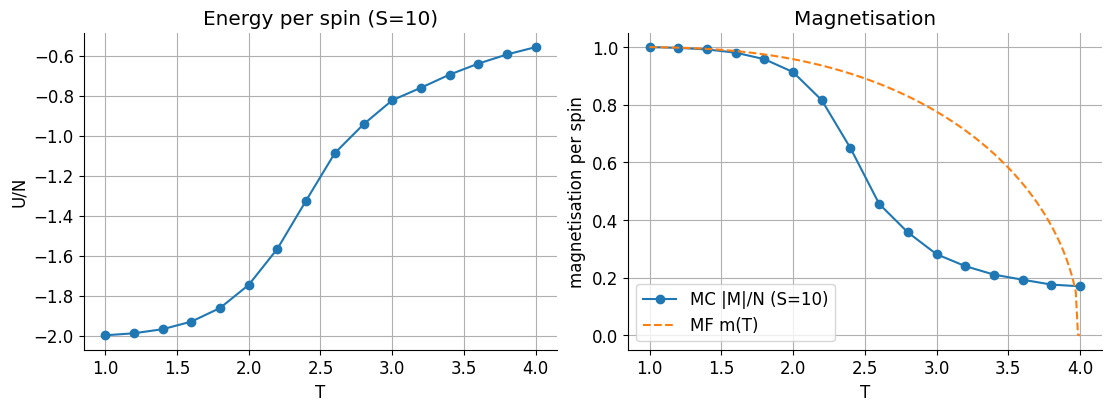

In [29]:
Ts, UNm, MNm = temp_scan(S=10, B=0.0)

# MF reference
Tgrid = np.linspace(1.0, 4.0, 200)
m_mf = np.array([mf_magnetisation(T, q=4, I=1.0) for T in Tgrid])

# Energy and magnetisation
fig, ax = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True)
ax[0].plot(Ts, UNm, "o-")
ax[0].set_xlabel("T"); ax[0].set_ylabel("U/N"); ax[0].set_title("Energy per spin (S=10)"); ax[0].grid(True)

ax[1].plot(Ts, MNm, "o-", label="MC |M|/N (S=10)")
ax[1].plot(Tgrid, m_mf, "--", label="MF m(T)")
ax[1].set_xlabel("T"); ax[1].set_ylabel("magnetisation per spin")
ax[1].set_title("Magnetisation"); ax[1].grid(True); ax[1].legend()


plt.show()

## Locating the critical temperature

To estimate the critical temperature we can use the **magnetic susceptibility** $\chi$, which is related to equilibrium fluctuations of the magnetisation.
For a time series of the per–spin magnetisation $m(t)=M(t)/N$ at fixed $T$ and $B=0$, we can use

$$
\chi \propto \frac{\langle m^2\rangle - \langle m\rangle^2}{T},
$$

and locate $T_c$ as the position of the peak of $\chi(T)$ (for a given finite lattice size).
To this end, we introduce the following functions:

In [6]:
def susceptibility_from_time_series(M_series, T):
    '''Estimate the magnetic susceptibility from a time series of m = M/N.

    We use the fluctuation–dissipation relation

        chi \propto ( <m^2> - <m>^2 ) / T.

    The overall normalisation (a factor N) is irrelevant for locating the peak
    of chi(T) on a finite lattice.
    '''
    m = M_series
    return (m.var(ddof=1) / T)

def estimate_Tc_by_susceptibility(S=40, Ts=None, sweeps=4000, burn=1500):
    '''Scan temperatures at B=0 and locate Tc from the peak of the susceptibility.'''
    if Ts is None:
        Ts = np.linspace(2.0, 3.0, 21)
    chis = []
    for T in Ts:
        Ms, Us = run_ising_2d(S=S, T=T, sweeps=sweeps, burn=burn, B=0.0,
                              init="random", rng=rng)
        chis.append(susceptibility_from_time_series(Ms, T))
    chis = np.asarray(chis)
    Tc = Ts[np.argmax(chis)]
    return Tc, Ts, chis


Estimated Tc (finite size, S=40): 2.333


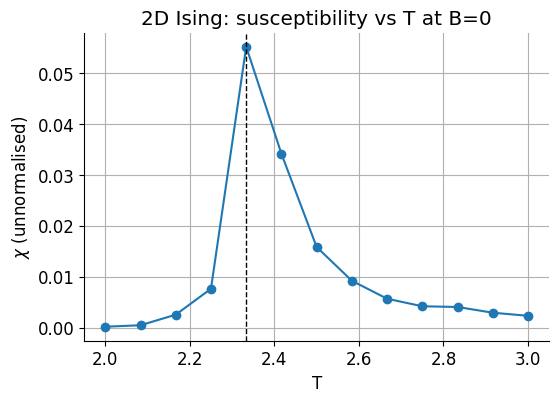

In [7]:
# Example: estimate Tc on a moderate lattice
S_for_Tc = 40
Ts = np.linspace(2.0, 3.0, 13)
Tc_est, Ts, chis = estimate_Tc_by_susceptibility(S=S_for_Tc, Ts=Ts,
                                                 sweeps=4000, burn=1500)
print(f"Estimated Tc (finite size, S={S_for_Tc}): {Tc_est:.3f}")

fig, ax = plt.subplots()
ax.plot(Ts, chis, "o-")
ax.axvline(Tc_est, color="k", linestyle="--", linewidth=1)
ax.set_xlabel("T")
ax.set_ylabel(r"$\chi$ (unnormalised)")
ax.set_title("2D Ising: susceptibility vs T at B=0")
plt.show()


## Magnetisation as a function of external field

Since - from the above estimation - we saw that $T_c \simeq 2.3$, let us to fix two temperatures:

* one **below** $T_c$, e.g. $T=2$,
* one **above** $T_c$, e.g. $T=3$,

and then scan several values of $B$ in the interval $-1 \le B \le 1$, measuring the mean magnetisation per spin $\langle M/\mu_B\rangle/N$.

We therefore implement a small helper that, for a fixed $T$, returns $\langle M/N\rangle$ as a function of $B$:

In [8]:
def magnetisation_vs_field(S=40, T=2.0, B_values=None,
                           sweeps=6000, burn=2000):
    '''Compute <M/N> as a function of external field B at fixed T.

    Parameters
    ----------
    S : int
        Lattice size.
    T : float
        Temperature.
    B_values : array-like or None
        Grid of field values. If None, we use a symmetric linspace in [-1, 1].
    sweeps, burn : int
        Total sweeps and burn-in length for each field value.

    Returns
    -------
    B_values : ndarray
        The array of fields used.
    M_means : ndarray
        Mean magnetisation per spin <M/N> at each field.
    '''
    if B_values is None:
        B_values = np.linspace(-1.0, 1.0, 11)
    B_values = np.asarray(B_values, dtype=float)

    means = []
    for B in B_values:
        Ms, Us = run_ising_2d(S=S, T=T, sweeps=sweeps, burn=burn, B=B,
                              init="random", rng=rng)
        means.append(Ms.mean())
    return B_values, np.asarray(means)


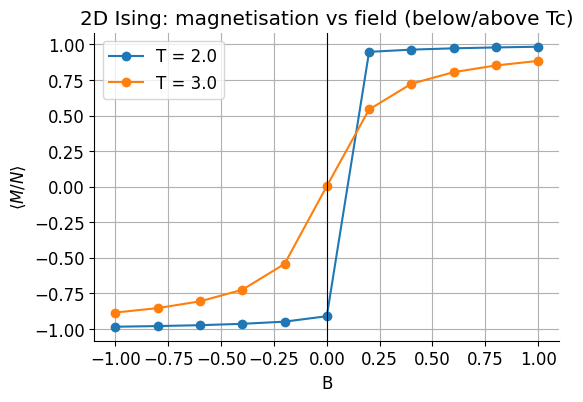

In [9]:
# Example: magnetisation curves below and above Tc
Bs = np.linspace(-1.0, 1.0, 11)

fig, ax = plt.subplots()
for T in [2.0, 3.0]:   # below and above Tc
    Bvals, Mvals = magnetisation_vs_field(S=40, T=T, B_values=Bs,
                                          sweeps=6000, burn=2000)
    ax.plot(Bvals, Mvals, "o-", label=f"T = {T}")

ax.axvline(0.0, color="k", linewidth=0.8)
ax.set_xlabel("B")
ax.set_ylabel(r"$\langle M/N \rangle$")
ax.set_title("2D Ising: magnetisation vs field (below/above Tc)")
ax.legend()
plt.show()


## 1D Ising model: exact solution and Metropolis simulation

We now turn to the **1D Ising model** with nearest–neighbour coupling and external field $B$. Here each spin has $q=2$ neighbours (left and right), and we impose periodic boundary conditions.

In the lectures, we derived the exact magnetisation using the **transfer-matrix** method, leading to

$$
M(T,B,N) = N \mu_B
\frac{\sinh x}{\sqrt{e^{-4y} + \sinh^2 x}}
\left(\frac{\lambda_1^N - \lambda_2^N}{\lambda_1^N + \lambda_2^N}\right),
\qquad x = \beta \mu_B B,\quad y = \beta I,
$$

where $\lambda_{1,2}(x,y)$ are the eigenvalues of the $2\times 2$ transfer matrix. 

Below, we first implement the eigenvalues and the exact magnetisation, and then build a Metropolis simulation to verify numerically that Metropolis results for $M(B)$ agree with the exact transfer-matrix formula.

In [30]:
def lambdas_1d(x, y):
    '''Transfer-matrix eigenvalues λ₁,₂(x, y) for the 1D Ising model in a field.

    Parameters
    ----------
    x : float or ndarray
        Shorthand for x = β μ_B B.
    y : float or ndarray
        Shorthand for y = β I, with I ≥ 0 the nearest–neighbour coupling.

    Returns
    -------
    lam1, lam2 : tuple of floats or ndarrays
        The two eigenvalues λ₁ ≥ λ₂ ≥ 0 of the 2×2 transfer matrix.
    '''
    # Helper: square root under the radical, safe for vectorised inputs
    rad = np.sqrt(np.maximum(0.0, np.exp(-2.0*y) + np.exp(2.0*y) * np.sinh(x)**2))
    lam1 = np.exp(y) * np.cosh(x) + rad
    lam2 = np.exp(y) * np.cosh(x) - rad
    return lam1, lam2

def M_exact_1d(T, B, N=100, I=1.0, muB=1.0):
    '''Exact magnetisation for the 1D Ising chain with periodic boundary conditions.

    The transfer-matrix derivation gives

        M(T, B, N) = N μ_B sinh x / sqrt(e^{-4y} + sinh^2 x)
                     * (λ₁^N - λ₂^N) / (λ₁^N + λ₂^N),

    where x = β μ_B B, y = β I and λ₁,₂ are returned by `lambdas_1d`.

    Parameters
    ----------
    T : float
        Temperature.
    B : float
        External field.
    N : int, default 100
        Number of spins in the chain.
    I : float, default 1.0
        Nearest–neighbour coupling.
    muB : float, default 1.0
        Magnetic moment per spin.

    Returns
    -------
    M : float
        Total magnetisation of the chain.
    '''
    beta = 1.0 / T
    x = beta * muB * B
    y = beta * I
    lam1, lam2 = lambdas_1d(x, y)

    # To avoid overflow in λ^N for large N we work with the ratio r = λ₂ / λ₁.
    r = lam2 / lam1
    num = 1.0 - r**N
    den = 1.0 + r**N
    prefactor = np.sinh(x) / np.sqrt(np.exp(-4.0*y) + np.sinh(x)**2)
    M = N * muB * prefactor * (num / den)
    return float(M)


The Metropolis algorithm in 1D is completely analogous to the 2D case:

1. We represent the configuration as a 1D array `spins[i] = ±1`, \(i=0,\dots,N-1\).
2. In one sweep we visit all sites in a random order.
3. For a given site \(i\) we compute the neighbour sum
   \(s_{\text{neigh}} = s_{i-1} + s_{i+1}\) using periodic boundaries.
4. The energy change for a flip \(s_i\to -s_i\) (in reduced units \(I=\mu_B=1\))
   is \(\Delta U = 2 s_i (B + s_{\text{neigh}})\).
5. We accept/reject the flip using the usual Metropolis rule.

We now implement this as a function that returns a time series of the magnetisation \(M\).

In [31]:
def run_ising_1d(N=100, T=2.0, B=0.0, sweeps=8000, burn=2000,
                 init="random", rng=None):
    '''Metropolis simulation of the 1D Ising chain with periodic boundaries.

    Parameters
    ----------
    N : int
        Number of spins in the chain.
    T : float
        Temperature.
    B : float
        External magnetic field.
    sweeps : int
        Total Metropolis sweeps.
    burn : int
        Number of initial sweeps discarded as burn-in.
    init : {"random", "aligned"}
        Initial configuration; "aligned" sets all spins to +1.
    rng : numpy.random.Generator or None

    Returns
    -------
    Ms : ndarray
        Time series of the total magnetisation M after burn-in.
    '''
    if rng is None:
        rng = np.random.default_rng()

    if init == "aligned":
        spins = np.ones(N, dtype=int)
    else:
        spins = rng.choice([-1, 1], size=N)

    idx = np.arange(N)
    Ms = []
    for s in range(sweeps):
        rng.shuffle(idx)
        for i in idx:
            si = spins[i]
            # Nearest neighbours with periodic boundary conditions
            neigh_sum = spins[(i - 1) % N] + spins[(i + 1) % N]
            # Here we use I = mu_B = 1 in reduced units.
            dU = 2.0 * si * (B + neigh_sum)
            if dU <= 0.0 or rng.random() < math.exp(-dU / T):
                spins[i] = -si
        if s >= burn:
            Ms.append(spins.sum())
    return np.asarray(Ms, dtype=float)


We can now verify that the Metropolis estimates of $M(B)$ agree with the exact transfer-matrix result at fixed $T$:

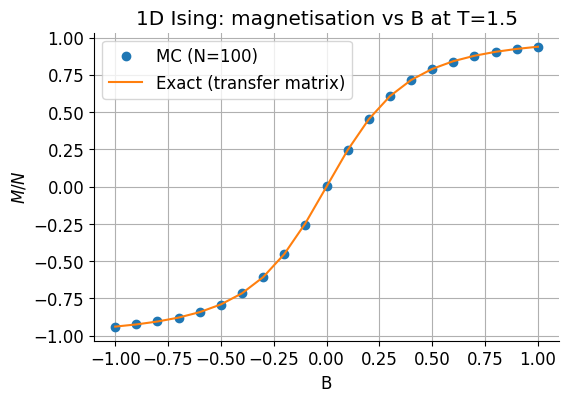

In [32]:
def compare_1d_exact_vs_mc(T=1.5, N=100, B_values=None,
                           sweeps=10000, burn=4000):
    '''Compare Metropolis estimates of M(B) with the exact transfer-matrix result.'''
    if B_values is None:
        B_values = np.linspace(-1.0, 1.0, 21)
    B_values = np.asarray(B_values, dtype=float)

    M_mc = []
    M_ex = []
    for B in B_values:
        Ms = run_ising_1d(N=N, T=T, B=B, sweeps=sweeps, burn=burn,
                          init="random", rng=rng)
        M_mc.append(Ms.mean())
        M_ex.append(M_exact_1d(T, B, N=N))
    M_mc = np.asarray(M_mc)
    M_ex = np.asarray(M_ex)

    fig, ax = plt.subplots()
    ax.plot(B_values, M_mc / N, "o", label=f"MC (N={N})")
    ax.plot(B_values, M_ex / N, "-", label="Exact (transfer matrix)")
    ax.set_xlabel("B")
    ax.set_ylabel(r"$M/N$")
    ax.set_title(f"1D Ising: magnetisation vs B at T={T}")
    ax.legend()
    plt.show()

# Example call:
compare_1d_exact_vs_mc(T=1.5, N=100)


Moreover, exploiting the functions defined above, we can check numerically that, for $B=0$, the average magnetisation per spin tends to zero for all $T>0$ as the system size and the simulation time
increase. 
(For finite $N$ one typically observes a non-zero $\langle |M|\rangle$, but $\langle M\rangle \to 0$ in the thermodynamic limit.)

In [33]:
def show_zero_field_magnetisation_vs_T(N=100, Ts=None,
                                       sweeps=12000, burn=4000):
    '''Demonstrate the absence of spontaneous magnetisation in 1D at B = 0.'''
    if Ts is None:
        Ts = [0.5, 1.0, 2.0, 3.0]
    vals = []
    for T in Ts:
        Ms = run_ising_1d(N=N, T=T, B=0.0, sweeps=sweeps, burn=burn,
                          init="random", rng=rng)
        vals.append(Ms.mean() / N)
    for T, v in zip(Ts, vals):
        print(f"T = {T:4.1f},   <M/N> ≈ {v: .4f}")

# Example call:
show_zero_field_magnetisation_vs_T(N=100)

T =  0.5,   <M/N> ≈ -0.1673
T =  1.0,   <M/N> ≈ -0.0069
T =  2.0,   <M/N> ≈ -0.0029
T =  3.0,   <M/N> ≈ -0.0001
